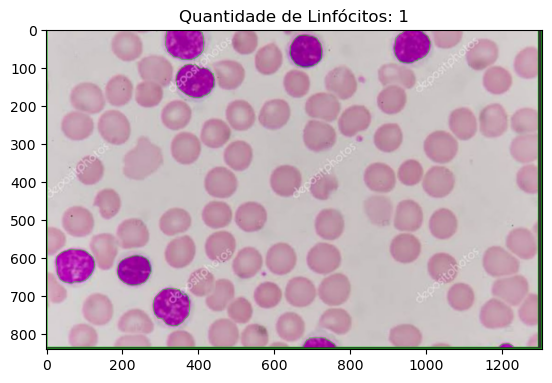

Quantidade de linfócitos: 1


In [22]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt

def apply_kmeans(image, k=3):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()].reshape(image.shape)
    return segmented_image

def process_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    kmeans_result = apply_kmeans(blurred, k=3)
    
    # Converter para escala de cinza e aplicar binarização
    gray = cv2.cvtColor(kmeans_result, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

    # Morfologia para limpar a imagem
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=3)
    
    # Contorno e objetos
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)  # Ajuste de threshold
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Aplicando Watershed para segmentação
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # Aplica o algoritmo Watershed
    cv2.watershed(image, markers)
    
    # Marcar os contornos com uma cor (por exemplo, verde)
    image[markers == -1] = [0, 255, 0]  # Contornos em verde
    
    # Criar uma imagem binária para encontrar os contornos
    binary_contours = np.zeros_like(markers, dtype=np.uint8)
    
    # A imagem binária será onde os contornos são -1
    binary_contours[markers == -1] = 255  # Contornos em branco
    
    # Inverter a imagem binária: fundo preto e contornos brancos
    binary_contours = cv2.bitwise_not(binary_contours)
    
    # Encontrar contornos na imagem binária
    contours, _ = cv2.findContours(binary_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Contar o número de contornos válidos (linfócitos)
    count_objects = len(contours)
    
    return image, count_objects


def open_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        image = cv2.imread(file_path)
        processed_image, count_lymphocytes = process_image(image)
        
        # Exibe a imagem processada em uma janela do matplotlib (no terminal)
        plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Quantidade de Linfócitos: {count_lymphocytes}')
        plt.show()

        # Exibe a quantidade de linfócitos no terminal
        print(f"Quantidade de linfócitos: {count_lymphocytes}")
        
        # Exibe a imagem processada na interface
        show_image(processed_image, lbl_image)

        # Atualiza a contagem de linfócitos na interface
        lbl_count.config(text=f"Quantidade de linfócitos: {count_lymphocytes}")

def show_image(image_array, label):
    # Converte a imagem para RGB
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(image_array)
    img_tk = ImageTk.PhotoImage(image=img)
    
    # Atualiza a imagem exibida na interface gráfica
    label.config(image=img_tk)
    label.image = img_tk  # Mantém uma referência à imagem

# Interface Tkinter
root = tk.Tk()
root.title("Detecção de Linfócitos")

# Botão para abrir imagem
btn_open = tk.Button(root, text="Selecionar Imagem", command=open_image)
btn_open.pack(pady=10)

# Rótulo para exibir a imagem
lbl_image = tk.Label(root)
lbl_image.pack()

# Rótulo para exibir a quantidade de linfócitos
lbl_count = tk.Label(root, text="Quantidade de linfócitos: 0", font=("Arial", 12))
lbl_count.pack(pady=10)

# Inicia a interface gráfica
root.mainloop()


In [1]:
import cv2
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np

# Função para processar a imagem com watershed
def process_image_with_watershed(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 1, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    cv2.watershed(image, markers)
    count_black = len(np.unique(markers)) - 2  # Subtrai fundo e borda

    image[markers == -1] = [0, 255, 0]  # Contornos em verde

    return image, count_black

# Função para abrir a imagem
def open_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        image = cv2.imread(file_path)

        # Aplicação de filtros para remover áreas indesejadas
        mask_red = (image[:, :, 2] < 190) & (image[:,:,2]>160)
        image[mask_red] = [0, 0, 0]

        mask_blue = (image[:, :, 0] > 160) & (image[:, :, 0] < 170)
        image[mask_blue] = [0, 0, 0]

        mask_green = (image[:, :, 1] > 140) & (image[:, :, 1] < 180)
        image[mask_green] = [0, 0, 0]
        
        black_mask = (image[:, :, 0] == 0) & (image[:, :, 1] == 0) & (image[:, :, 2] == 0)
        binary_image = np.zeros_like(image[:, :, 0])
        binary_image[black_mask] = 255

        processed_image, count_black = process_image_with_watershed(image)

        # Atualiza o texto da label sem recriar
        lbl_count.config(text=f"Quantidade de hemácias: {count_black}")

        # Exibe as imagens
        show_image(processed_image, lbl_image)
        show_image(binary_image, lbl_binary_image, gray=True)

# Função para exibir a imagem no label
def show_image(image_array, label, gray=False):
    """ Converte e exibe uma imagem no label do Tkinter. """
    if gray:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
    else:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

    img = Image.fromarray(image_array)
    img_tk = ImageTk.PhotoImage(image=img)

    label.config(image=img_tk)
    label.image = img_tk  # Armazena a referência da imagem para evitar problemas de coleta de lixo

# Criação da interface gráfica
root = tk.Tk()
root.title("Detecção de Hemácias com OpenCV")

btn_open = tk.Button(root, text="Selecionar Imagem", command=open_image)
btn_open.pack(pady=10)

lbl_image = tk.Label(root)
lbl_image.pack()

lbl_binary_image = tk.Label(root)
lbl_binary_image.pack()

# Definição do label de contagem globalmente para evitar desaparecimento
lbl_count = tk.Label(root, text="Quantidade de hemácias: 0", font=("Arial", 12))
lbl_count.pack(pady=10)

root.mainloop()




Quantidade de células detectadas: 69


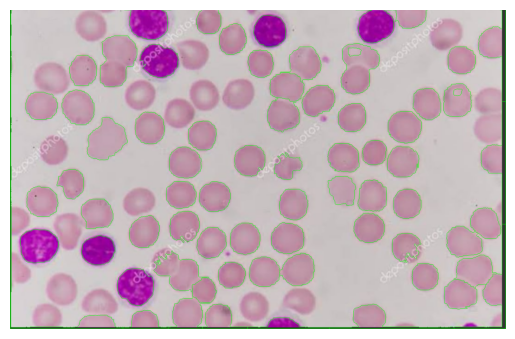

In [12]:
import cv2
import numpy as np
from tkinter import filedialog
from PIL import Image, ImageTk
from IPython.display import display, Image as IPImage
import matplotlib.pyplot as plt

# Função para processar a imagem
def process_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
    vectorized = lab.reshape((-1, 3))
    vectorized = np.float32(vectorized)

    # Aplica K-Means
    K = 3
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(vectorized, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented = centers[labels.flatten()].reshape(image.shape)

    # Converte para escala de cinza e aplica binarização
    gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Remove ruídos
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Marca fundo e foreground para Watershed
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marcações para Watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Aplica Watershed
    cv2.watershed(image, markers)
    image[markers == -1] = [0, 255, 0]  # Contornos em verde

    # Conta células segmentadas
    unique_labels = np.unique(markers)
    count_cells = len(unique_labels) - 2  # Remove fundo e borda

    return image, count_cells

# Função para abrir e processar a imagem
def open_image(file_path):
    image = cv2.imread(file_path)
    processed_image, count_cells = process_image(image)

    # Exibe a quantidade de células detectadas diretamente na célula do Jupyter
    print(f"Quantidade de células detectadas: {count_cells}")

    # Exibe a imagem processada
    show_image(processed_image)

# Função para exibir imagem
def show_image(image_array):
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(image_array)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos
    plt.show()

# Exemplo de uso: Selecione a imagem localmente e passe o caminho para open_image
# Caminho do arquivo da imagem
file_path = filedialog.askopenfilename()  # Selecione o arquivo no Jupyter

# Abrir e processar a imagem
if file_path:
    open_image(file_path)


In [ ]:
import cv2
import numpy as np
from tkinter import filedialog
from PIL import Image, ImageTk
from IPython.display import display, Image as IPImage
import matplotlib.pyplot as plt

# Função para processar a imagem
def process_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
    vectorized = lab.reshape((-1, 3))
    vectorized = np.float32(vectorized)

    # Aplica K-Means
    K = 6
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(vectorized, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented = centers[labels.flatten()].reshape(image.shape)

    # Converte para escala de cinza e aplica binarização
    gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Remove ruídos
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Marca fundo e foreground para Watershed
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marcações para Watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Aplica Watershed
    cv2.watershed(image, markers)
    image[markers == -1] = [0, 255, 0]  # Contornos em verde

    # Conta células segmentadas
    unique_labels = np.unique(markers)
    count_cells = len(unique_labels) - 2  # Remove fundo e borda

    return image, count_cells

# Função para abrir e processar a imagem
def open_image(file_path):
    image = cv2.imread(file_path)
    processed_image, count_cells = process_image(image)

    # Exibe a quantidade de células detectadas diretamente na célula do Jupyter
    print(f"Quantidade de células detectadas: {count_cells}")

    # Exibe a imagem processada
    show_image(processed_image)

# Função para exibir imagem
def show_image(image_array):
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(image_array)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos
    plt.show()

# Exemplo de uso: Selecione a imagem localmente e passe o caminho para open_image
# Caminho do arquivo da imagem
file_path = filedialog.askopenfilename()  # Selecione o arquivo no Jupyter

# Abrir e processar a imagem
if file_path:
    open_image(file_path)
